# Detecting Suicidal Intentions
Provided are labeled tweets in the Russian language, with the goal of training a model to determine whether the author of a tweet expresses suicidal intentions.
The data is sourced from Kaggle:
* https://www.kaggle.com/datasets/eldamar1717/depression-suicide-twits-ru

In [1]:
#!pip install nltk optuna wordcloud catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from optuna.integration import OptunaSearchCV
from optuna import distributions
from wordcloud import WordCloud
from catboost import CatBoostClassifier
from wordcloud import STOPWORDS

In [3]:
#nltk.download()

## Data Loading and Initial Analysis

In [4]:
df_tweets = pd.read_json("RU_suicide_tweets.json", orient='records')

providing сolumn names

In [5]:
df_tweets.columns = ['tweet', 'sentiment']

explore basic information

In [6]:
print(df_tweets.info())
df_tweets.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      47997 non-null  object
 1   sentiment  47997 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB
None


,tweet,sentiment
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide
5,"Честно говоря, я не знаю, что я вообще здесь д...",suicide
6,[Триггерное предупреждение] Оправдание за нане...,suicide
7,Это закончится сегодня вечером. Я больше не мо...,suicide
8,"Все хотят быть «резкими», и это заставляет мен...",non-suicide
9,Моя жизнь закончилась в 20 лет. Всем привет. Я...,suicide


Сheck for omissions and duplicates

In [7]:
print("Number of duplicates =", df_tweets.duplicated().sum())
print("Number of passes ", df_tweets.isna().sum(), sep='\n')

Number of duplicates = 4
Number of passes 
tweet        0
sentiment    0
dtype: int64


In [8]:
df_tweets = df_tweets.drop_duplicates()

Check the column with markers for typos

In [9]:
df_tweets['sentiment'].unique()

array(['suicide', 'non-suicide'], dtype=object)

## Data analysis

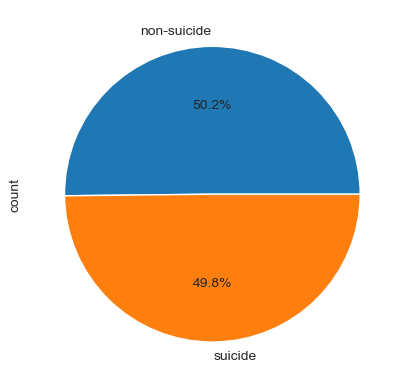

In [10]:
df_tweets['sentiment'].value_counts().plot.pie(autopct="%1.1f%%");

There is no class imbalance in the presented data

Write some functions to create a word cloud

In [11]:
# Function to concatenate words in a list into a single string
def str_corpus(corpus):
    str_corpus = ''
    # Concatenate each word in the list
    for i in corpus:
        str_corpus += ' ' + i
    # Remove leading and trailing whitespaces
    str_corpus = str_corpus.strip()
    return str_corpus

# Function to extract all words from a list of phrases
def get_corpus(data):
    corpus = []
    # Iterate through each phrase in the data
    for phrase in data:
        # Split each phrase into words and add them to the corpus list
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Function to generate a WordCloud
def get_wordcloud(corpus):
    # Create a WordCloud with specified parameters
    wordCloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        width=3000,
        height=2500,
        max_words=200,
        random_state=42
    ).generate(str_corpus(corpus))  # Generate WordCloud using the concatenated string
    return wordCloud

Use the written functions

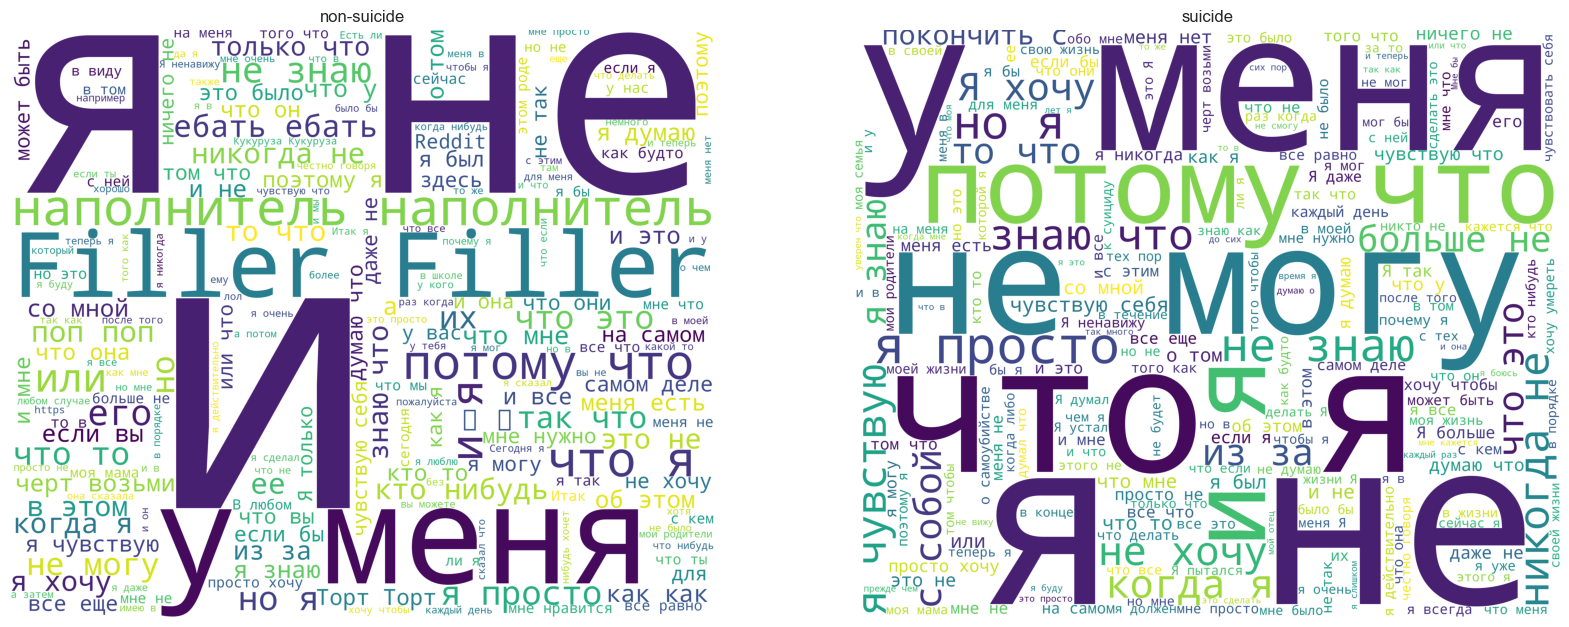

In [12]:
# Create a figure with a specified size
fig = plt.figure(figsize=(20, 8))

# Plot the WordCloud for non-suicide tweets in the first subplot
plt.subplot(1, 2, 1)

# Get the corpus for non-suicide tweets using the 'tweet' column in the DataFrame
corpus_non_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'non-suicide']['tweet'].values)

# Generate a WordCloud for the non-suicide tweets
wordcloud_non_suicide = get_wordcloud(corpus_non_suicide)

# Display the WordCloud for non-suicide tweets in the first subplot
plt.imshow(wordcloud_non_suicide)
plt.title('non-suicide')
plt.axis('off')

# Plot the WordCloud for suicide tweets in the second subplot
plt.subplot(1, 2, 2)

# Get the corpus for suicide tweets using the 'tweet' column in the DataFrame
corpus_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'suicide']['tweet'].values)

# Generate a WordCloud for the suicide tweets
wordcloud_suicide = get_wordcloud(corpus_suicide)

# Display the WordCloud for suicide tweets in the second subplot
plt.imshow(wordcloud_suicide)
plt.title('suicide')
plt.axis('off')

# Show the figure with both WordClouds
plt.show();

## Text preprocessing
To select a model, we will use only the first 10,000 lines, otherwise the training will take too long

In [13]:
df_tweets = df_tweets.head(10000)

Let's write a function for processing the text of a tweet

In [14]:
def process_tweet(text):
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text into words and convert to lowercase
    tokens = word_tokenize(text.lower())

    # Create a set of Russian stop words
    stop_words_set = set(stopwords.words('russian'))

    # Create a Snowball stemmer for Russian language
    stemmer = SnowballStemmer('russian')

    # Apply stemming to each word and remove stop words
    text = [stemmer.stem(word) for word in tokens if word not in stop_words_set]

    # Join the processed words into a single string
    return ' '.join(text)

Apply the written function by creating a new column

In [15]:
df_tweets['tweet_stem'] = df_tweets['tweet'].apply(process_tweet)

Check the word cloud after processing the data

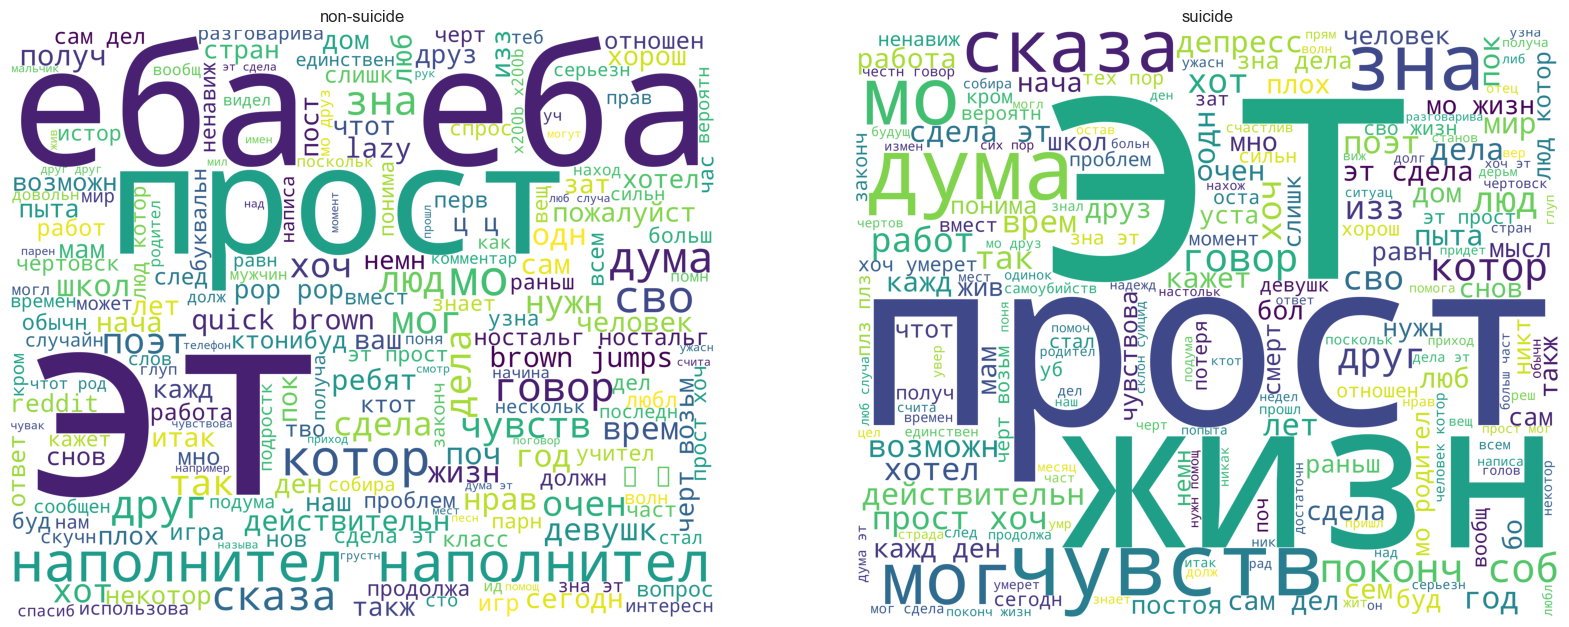

In [16]:
# Create a figure with a specified size
fig = plt.figure(figsize=(20, 8))

# Get the corpus for non-suicide tweets using the 'tweet_stem' column in the DataFrame
corpus_non_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'non-suicide']['tweet_stem'].values)

# Generate a WordCloud for the non-suicide tweets
wordcloud_non_suicide = get_wordcloud(corpus_non_suicide)

# Plot the WordCloud for non-suicide tweets in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_non_suicide)
plt.title('non-suicide')
plt.axis('off')

# Get the corpus for suicide tweets using the 'tweet_stem' column in the DataFrame
corpus_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'suicide']['tweet_stem'].values)

# Generate a WordCloud for the suicide tweets
wordcloud_suicide = get_wordcloud(corpus_suicide)

# Plot the WordCloud for suicide tweets in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_suicide)
plt.title('suicide')
plt.axis('off')

# Show the figure with both WordClouds
plt.show();

Prepare the data for modeling

In [17]:
# Drop the 'tweet' column from the DataFrame
df_tweets_preprocessed = df_tweets.drop('tweet', axis=1)

# Drop duplicate rows in the preprocessed DataFrame
df_tweets_preprocessed.drop_duplicates(inplace=True)

# Drop rows with missing values in the preprocessed DataFrame
df_tweets_preprocessed.dropna(inplace=True)

Encode the target variable

In [18]:
# Instantiate a LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'sentiment' column in the DataFrame
df_tweets_preprocessed['sentiment'] = label_encoder.fit_transform(df_tweets_preprocessed['sentiment'])

# Access the classes that were encoded
classes_encoded = label_encoder.classes_

# Print the encoded classes
print(classes_encoded)

['non-suicide' 'suicide']


## Choosing the best simple model

Choose a random state for reproducibility of the results when running the code again.

In [19]:
RANDOM_STATE = 42

Create a pipeline to iterate through the models

In [20]:
final_p = Pipeline(steps=[
    ('model', LogisticRegression())
])

Create a dictionary with iterable models

In [21]:
param_grid = [
    {
        'model': [
            LogisticRegression(random_state=RANDOM_STATE),
            MultinomialNB(),
            SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
            RandomForestClassifier(random_state=RANDOM_STATE)
        ]          
    }
]

Create the GridSearchCV object itself, which will iterate over the models and evaluate them for cross validation

In [22]:
grid_search = GridSearchCV(
    final_p,          # 'final_p' is the pipiline
    param_grid,        # 'param_grid' is a dictionary specifying to search over
    cv=5,              # 'cv' is the number of cross-validation folds
    scoring='roc_auc', # 'scoring' is the evaluation metric used for optimization (ROC AUC in this case)
    n_jobs=-1          # 'n_jobs' is the number of CPU cores to use for parallelization (-1 means using all available cores)
)

Splitting data into target and input attributes

In [23]:
X = df_tweets_preprocessed['tweet_stem']
y = df_tweets_preprocessed['sentiment']

Splitting the data into training and test samples

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Vectorizing tweets

In [25]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data to TF-IDF representation
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Let's use the grid search to find the best model

In [26]:
# Fit the GridSearchCV object on the TF-IDF transformed training data and labels
grid_search.fit(X_train_tfidf, y_train)

# Retrieve the best-performing model from the search
best_model_classification = grid_search.best_estimator_

Display the parameters of the best model on the screen

In [27]:
print('The best model and its parameters:\n\n', best_model_classification)
print ('The metric of the best model in the training sample:', grid_search.best_score_)

The best model and its parameters:

 Pipeline(steps=[('model',
                 SVC(kernel='linear', probability=True, random_state=42))])
The metric of the best model in the training sample: 0.9645296918535646


Look at the results of other models

In [28]:
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
sorted_results = sorted_results[['params', 'mean_test_score']]
sorted_results

,params,mean_test_score
2,"{'model': SVC(kernel='linear', probability=Tru...",0.964530
0,{'model': LogisticRegression(random_state=42)},0.961359
1,{'model': MultinomialNB()},0.960193
3,{'model': RandomForestClassifier(random_state=...,0.945476


## Selection of hyperparameters for the best model

Let's use OptunaSearch to select hyperparameters

In [29]:
# Define hyperparameter search space using Optuna distributions
parameters = {
    'kernel': distributions.CategoricalDistribution(['linear', 'rbf', 'poly']),
    'C': distributions.FloatDistribution(low=0.01, high=100.0, log=True),
    'gamma': distributions.FloatDistribution(low=0.001, high=1.0, log=True)
}

# Create an SVM classifier with probability estimates
model_svc = SVC(random_state=RANDOM_STATE, probability=True)

# Set up OptunaSearchCV for hyperparameter optimization
oscv = OptunaSearchCV(
    model_svc,                  # Classifier to be optimized
    parameters,                 # Hyperparameter search space
    cv=5,                       # Number of cross-validation folds
    n_trials=15,                # Number of optimization trials
    scoring='roc_auc',          # Evaluation metric for optimization
    verbose=0,                  # Verbosity level (0 for no output)
    random_state=RANDOM_STATE   # Random state for reproducibility
)

C:\Users\user\AppData\Local\Temp\ipykernel_3424\3094349363.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(


Find the best set of hyperparameters

In [30]:
# Fit the OptunaSearchCV object on the TF-IDF transformed training data and labels
oscv.fit(X_train_tfidf, y_train)

# Print the best hyperparameters found during the optimization
print("Best hyperparameters:", oscv.best_params_)

# Retrieve the best SVM model from the search
best_svm_model = oscv.best_estimator_

[I 2024-02-02 20:05:03,687] A new study created in memory with name: no-name-cdbb51be-1ef9-4478-957d-9c47359b5d84
[I 2024-02-02 20:13:02,176] Trial 0 finished with value: 0.9200153325641759 and parameters: {'kernel': 'rbf', 'C': 0.18957846572342554, 'gamma': 0.02854707256092785}. Best is trial 0 with value: 0.9200153325641759.
[I 2024-02-02 20:18:16,693] Trial 1 finished with value: 0.9448124914843741 and parameters: {'kernel': 'linear', 'C': 0.05068567405352181, 'gamma': 0.00902891843360715}. Best is trial 1 with value: 0.9448124914843741.
[I 2024-02-02 20:27:59,213] Trial 2 finished with value: 0.9187237376954245 and parameters: {'kernel': 'rbf', 'C': 0.088764223829748, 'gamma': 0.014714978674351281}. Best is trial 1 with value: 0.9448124914843741.
[I 2024-02-02 20:37:16,008] Trial 3 finished with value: 0.923929918457677 and parameters: {'kernel': 'poly', 'C': 0.6876455645022199, 'gamma': 0.7196813352927308}. Best is trial 1 with value: 0.9448124914843741.
[I 2024-02-02 20:47:12,737

Best hyperparameters: {'kernel': 'rbf', 'C': 3.7014279142044115, 'gamma': 0.0727675403200646}


### Checking the model on test data

Create a function to evaluate the model

In [35]:
def check_model(model, X, y):
    # Make predictions and calculate probability estimates
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    # Display classification report
    print(classification_report(y, y_pred))

    # Confusion Matrix
    conf_mat = confusion_matrix(y, y_pred, normalize='true')

    # Create a subplot with 1 row and 2 columns
    plt.figure(figsize=(12, 6))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_mat, annot=True, fmt='1.2f', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f}%)'.format(roc_auc * 100))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

Checking the SVC model with standard hyperparameters

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1257
           1       0.93      0.90      0.92      1243

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500


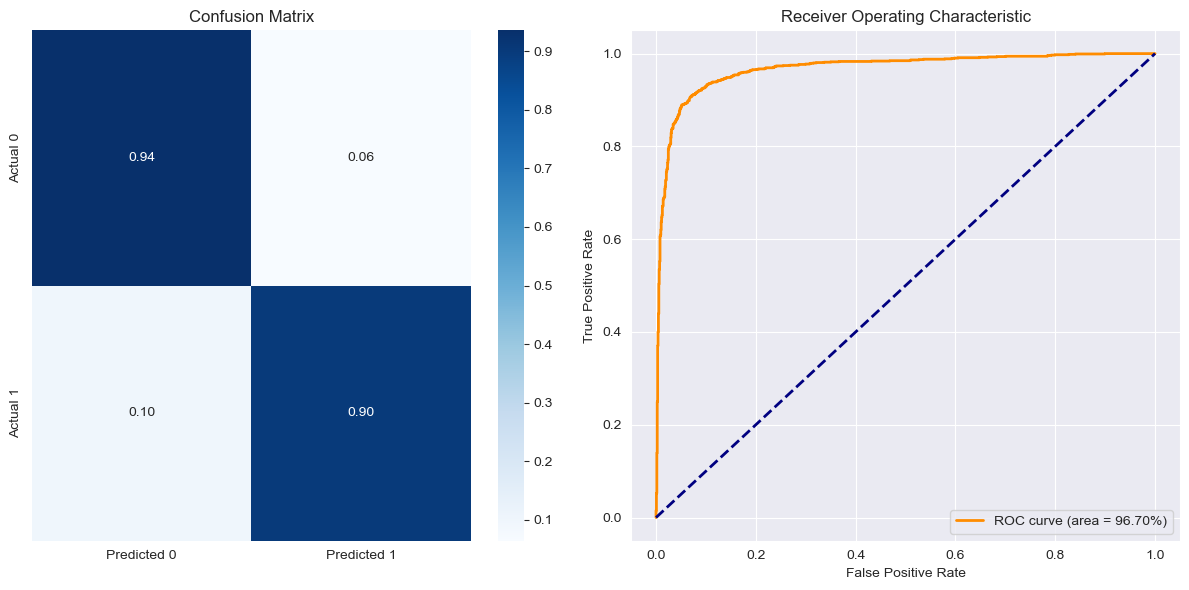

In [36]:
check_model(best_model_classification, X_test_tfidf, y_test)

Checking the SVC model with selected hyperparameters

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1257
           1       0.94      0.89      0.92      1243

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500


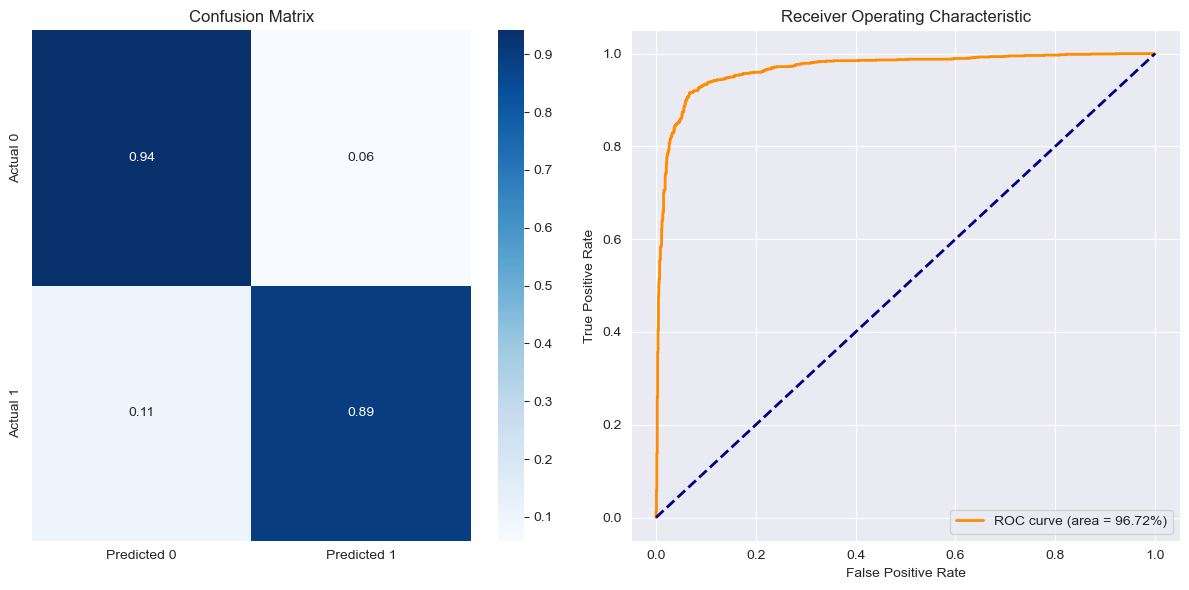

In [37]:
check_model(best_svm_model, X_test_tfidf, y_test)

## Using a more complex model

Let's use the more advanced CatBoost model for the same task

In [38]:
# Instantiate a CatBoostClassifier with specified parameters
model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.05, loss_function='Logloss', rsm=0.8, verbose=False)

# Fit the model on the TF-IDF transformed training data and labels
model.fit(X_train_tfidf, y_train);

Check the Catbots metric in the training sample

In [39]:
# Calculate the ROC-AUC score for the CatBoost model on the training set
catBoost_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train_tfidf)[:, 1])

# Print the ROC-AUC score
print("ROC-AUC score =", catBoost_roc_auc)

ROC-AUC score = 0.9870368424486202


As you can see, the metric is overestimated, most likely there was a retraining and the result will not be so impressive on the test data

Checking CatBoost on test data

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1257
           1       0.93      0.86      0.89      1243

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500


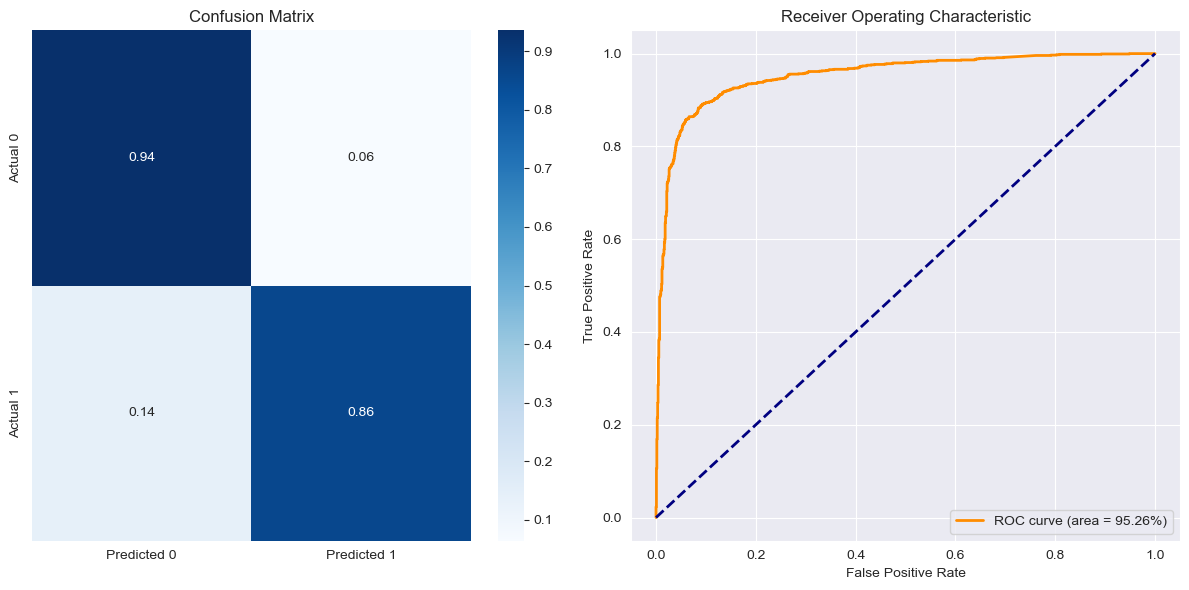

In [40]:
check_model(model, X_test_tfidf, y_test)

## Conclusion
* Punctuation marks and stop words were removed when processing tweets, while the rest of the text was split into tokens and processed using SnowballStemmer and then vectorized using TfidfVectorizer.
* 5 models were used - SVC, LogisticRegression, randomForest, MultinomialNB and CatBoost, as practice has shown, the first 4 models, although simpler, showed high efficiency of their roc-auc score was not much different from CatBoost, while the learning rate was several times higher.
* The best model was the SVC with a roc-auc score = 0.967 in the test sample